# Set up a simple thermal model
This thermal model has three stages, representing a cryostat with a fixed outer shell temperature near room temp, and a fixed inner temperature, representing a fixed thermal bath.

Middle Stage Support length = 0.029 m, Area = 4.032e-05 m²
length = 3.4641016151377544 in
Inner Stage Support length = 0.088 m, Area = 4.032e-05 m²
Radiation: Middle -> Inner
	Plate area: 0.037 m²
	Wall area: 0.103 m²
	Total surface area: 0.177 m²
	Power: 8.28e-01 W
middle_shell_height = 9.0 in
Radiation: Outer -> Middle
	Plate area: 0.053 m²
	Wall area: 0.187 m²
	Total surface area: 0.293 m²
	Power: 5.27e+00 W
Inner Shell: Height = 5.999999999999999 in, Width = 8.5 in
Middle Shell: Height = 9.0 in, Width = 10.25 in
IDIOT CHECKS:
	CONDUCTION:
		ConInt G10warp from 295 -> 252.01 K: 35.949 W/K
		ConInt G10warp from 252.01 -> 80 K: 103.287 W/K
		Outer -> Middle Strap Heat Flow: 295 -> 252.01 K: 0.049 W/K
		Middle -> Inner Strap Heat Flow: 252.01 -> 80 K: 0.047 W/K
		Outer -> Middle Conduction Total Power: 295 -> 252.01 K: 0.395 W
		Middle -> Inner Conduction Total Power: 252.01 -> 80 K: 0.379 W
	RADIATION:
		Outer -> Middle Radiation: Area = 0.374 m²
		Middle -> Inner Radiation: Area = 0.

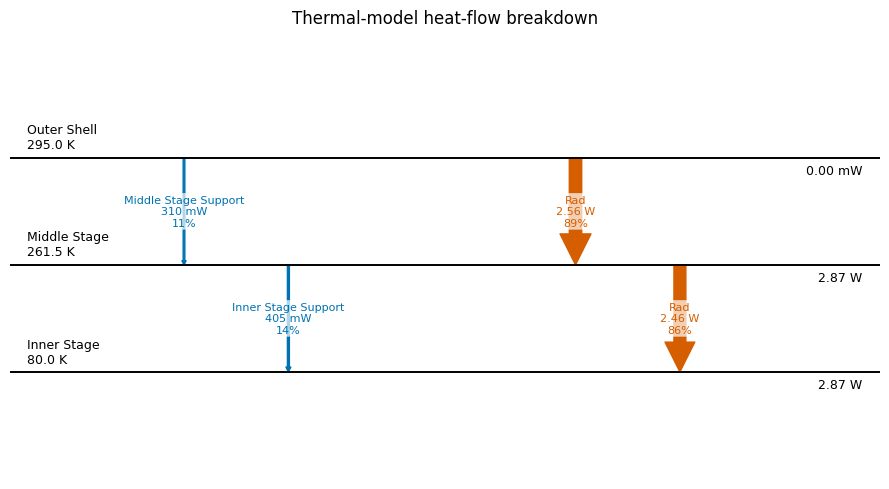

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u

from cryotherm import DATA_PATH                      # packaged resource
from cryotherm.material_db import MaterialDatabase
from cryotherm.stage import Stage
from cryotherm.conduction import Conduction
from cryotherm.radiation import Radiation
from cryotherm.solver import ThermalModel
from cryotherm.visualize import visualize_model   # or paste the code block once


in_to_m = 0.0254  # conversion factor from inches to metres


# ---------------------------------------------------------------------
# Material DB
# ---------------------------------------------------------------------
db = MaterialDatabase(DATA_PATH)



# ---------------------------------------------------------------------
#  Stages
# ---------------------------------------------------------------------
outer_shell_temp = 295  # K
middle_stage_temp = 200  # K
inner_stage_temp = 80  # K

outer = Stage("Outer Shell", outer_shell_temp, fixed=True)
middle = Stage("Middle Stage", middle_stage_temp, fixed=False)
use_fridge = False
if use_fridge:
    inner = Stage("Inner Stage", inner_stage_temp, fridge_curve="CryotelGT", fixed=False)
else:
    inner = Stage("Inner Stage", inner_stage_temp, fixed=True)

# ---------------------------------------------------------------------
#  Conduction
# ---------------------------------------------------------------------
standoff_material = "G10warp"  # material of the support cylinder
# Middle Stage Support
support_angle = 60  # degrees between supports
height_above_base = 1.5*in_to_m # height in metres\
length = height_above_base/np.sin(np.radians(support_angle)) # height in metres
width = 0.5*in_to_m # width in metres
thickness = 0.125*in_to_m # thickness in metres
number = 8  # number of support rods
# set up the support using the geometric methods
middle_stage_mech_support = Conduction(outer, middle, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=standoff_material, mat_db=db, method = "legacy",
                                name="Middle Stage Support")
print(f"Middle Stage Support length = {middle_stage_mech_support.length:.3f} m, Area = {middle_stage_mech_support.area:.3e} m²")


# Inner Stage Support



height_between_stages = 3.25*in_to_m # height in metres


support_angle = 60  # degrees between supports
length = height_between_stages/np.sin(np.radians(support_angle)) # height in metres
print(f"length = {length/in_to_m} in")
width = 0.5*in_to_m # width in metres
thickness = 0.125*in_to_m # thickness in metres
number = 8  # number of support rods
# set up the support using the geometric methods
inner_stage_mech_support = Conduction(middle, inner, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=standoff_material, mat_db=db, method = "legacy",
                                name="Inner Stage Support")

print(f"Inner Stage Support length = {inner_stage_mech_support.length:.3f} m, Area = {inner_stage_mech_support.area:.3e} m²")




# ---------------------------------------------------------------------
# Radiation
# ---------------------------------------------------------------------

# Radiation: Middle -> Inner
inner_shell_diameter = 8.5*in_to_m # outer diameter in metres
inner_shell_height = 6.0*in_to_m # height in metres
area_plate = inner_shell_diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * inner_shell_diameter * inner_shell_height  # area of the cylindrical wall
total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
emissivity_outer = 0.08
emissivity_inner = 0.08

#radiation_middle_to_inner = Radiation(middle, inner, type = "cylinder", diameter = diameter, height = height, emissivity1=emissivity_outer, emissivity2=emissivity_inner,
#                                      name = None)
radiation_middle_to_inner = Radiation(middle, inner, type = "box", length = inner_shell_diameter, width = inner_shell_diameter, height = inner_shell_height, 
                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name = None)
print("Radiation: Middle -> Inner")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_middle_to_inner.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")


# Radiation: Outer -> Middle
middle_shell_diameter = 10.25*in_to_m # outer diameter
middle_shell_height = inner_shell_height + height_between_stages # height in metres
print(f"middle_shell_height = {middle_shell_height/in_to_m} in")
area_plate = middle_shell_diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * middle_shell_diameter * middle_shell_height  # area of the cylindrical wall

total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
# Emissivity values for the outer and inner surfaces
emissivity_outer = 0.08
emissivity_inner = 0.08

#radiation_outer_to_middle = Radiation(outer, middle, type = "cylinder", diameter = diameter, 
#                                      height = height, 
#                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
#                                      name= None)
radiation_outer_to_middle = Radiation(outer, middle, type = "box", 
                                      length = middle_shell_diameter, width = middle_shell_diameter, height = middle_shell_height, 
                                      emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name= None)
print("Radiation: Outer -> Middle")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_outer_to_middle.heat_flow(outer_shell_temp, middle_stage_temp):.2e} W")

print(f"Inner Shell: Height = {inner_shell_height/in_to_m} in, Width = {inner_shell_diameter/in_to_m} in")
print(f"Middle Shell: Height = {middle_shell_height/in_to_m} in, Width = {middle_shell_diameter/in_to_m} in")

# ---------------------------------------------------------------------
# IDIOT CHECKS AGAINST EXCEL MODEL
# ---------------------------------------------------------------------
outer_stage_check_temp = 295  # K
middle_stage_check_temp = 252.01 # K
inner_stage_check_temp = 80  # K
print("IDIOT CHECKS:")
print("\tCONDUCTION:")
print(f"\t\tConInt {standoff_material} from {outer_stage_check_temp} -> {middle_stage_check_temp} K: {db.get_integral(standoff_material, T1 = outer_stage_check_temp, T2 = middle_stage_check_temp, method='legacy'):.3f} W/K")
print(f"\t\tConInt {standoff_material} from {middle_stage_check_temp} -> {inner_stage_check_temp} K: {db.get_integral(standoff_material, T1 = middle_stage_check_temp, T2 = inner_stage_check_temp, method='legacy'):.3f} W/K")
print(f"\t\tOuter -> Middle Strap Heat Flow: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {middle_stage_mech_support._strap_heat(outer_stage_check_temp, middle_stage_check_temp):.3f} W/K")
print(f"\t\tMiddle -> Inner Strap Heat Flow: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {inner_stage_mech_support._strap_heat(middle_stage_check_temp, inner_stage_check_temp):.3f} W/K")
print(f"\t\tOuter -> Middle Conduction Total Power: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {middle_stage_mech_support.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Conduction Total Power: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {inner_stage_mech_support.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

print("\tRADIATION:")
print(f"\t\tOuter -> Middle Radiation: Area = {radiation_outer_to_middle.area:.3f} m²")
print(f"\t\tMiddle -> Inner Radiation: Area = {radiation_middle_to_inner.area:.3f} m²")
print(f"\t\tOuter -> Middle Radiation Power: {outer_stage_check_temp} -> {middle_stage_check_temp} K: {radiation_outer_to_middle.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Radiation Power: {middle_stage_check_temp} -> {inner_stage_check_temp} K: {radiation_middle_to_inner.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")

print("\tTOTALS")
print(f"\t\tOuter -> Middle Total Power: {middle_stage_mech_support.heat_flow(outer_stage_check_temp, middle_stage_check_temp) + radiation_outer_to_middle.heat_flow(outer_stage_check_temp, middle_stage_check_temp):.3f} W")
print(f"\t\tMiddle -> Inner Total Power: {inner_stage_mech_support.heat_flow(middle_stage_check_temp, inner_stage_check_temp) + radiation_middle_to_inner.heat_flow(middle_stage_check_temp, inner_stage_check_temp):.3f} W")
# ---------------------------------------------------------------------
#  Solve
# ---------------------------------------------------------------------
model = ThermalModel(
    stages=[outer, middle, inner],
    conductors=[
        middle_stage_mech_support, 
        inner_stage_mech_support, 
        ],
    radiators=[radiation_outer_to_middle, radiation_middle_to_inner],
)

model.solve()                     # raises if the optimizer fails

for s in model.stages:
    print(f"{s.name:15s}:  {s.temperature:6.2f} K   netQ={s.net_heat_flow:+8.4f} W")

visualize_model(model, scale = 50)

model.report()


# Compare to Single Cold Stage



In [2]:
# Only Outer and Inner Stages

# ---------------------------------------------------------------------
#  Stages
# ---------------------------------------------------------------------
outer_shell_temp = 295  # K
inner_stage_temp = 80  # K

outer = Stage("Outer Shell", outer_shell_temp, fixed=True)
inner = Stage("Inner Stage", inner_stage_temp, fixed=True)

# ---------------------------------------------------------------------
#  Conduction
# ---------------------------------------------------------------------



# Inner Stage Support
length = 6*in_to_m # height in metres
width = 0.5*in_to_m # width in metres
thickness = 0.1*in_to_m # thickness in metres
material = "G10warp"  # material of the support cylinder
number = 6  # number of support rods
# set up the support using the geometric methods
inner_stage_mech_support = Conduction(outer, inner, type = "rect", width=width, thickness=thickness,
                                length=length, number=number, 
                                material=material, mat_db=db, method = "legacy",
                                name="Inner Stage Support")


# Cabling: Outer -> Inner
outer_dia = 0.0001  # outer diameter in metres
length = 0.1  # length in metres
material = "SS304L"  # material of the support cylinder
number = 10  # number of cables
cabling_outer_to_inner = Conduction(outer, inner, type = "cylinder", outer_dia=outer_dia, length=length, number=number,
                     material=material, mat_db=db, method = "legacy", name = "Cabling")

# Diagnostics/Debugging
area = np.pi * (outer_dia**2) / 4  # cross-sectional area
print("Cabling: Outer -> Inner")
print(f"\tMaterial: {material}")
print(f"\tOuter diameter: {outer_dia} m")
print(f"\tLength: {length} m")
print(f"\tCross-sectional area: {area:.3e} m²")
print(f"\tA/L: {area/length:.2e} m")
print(f"\tConInt: {db.get_integral(material, T1 = middle_stage_temp, T2 = inner_stage_temp, method='legacy'):.3f} W/K")

print(f"\tPower: {cabling_middle_to_inner.heat_flow(middle_stage_temp, inner_stage_temp):.2e} W")

# ---------------------------------------------------------------------
# Radiation
# ---------------------------------------------------------------------


# Radiation: Outer -> Inner
diameter = 11.5*in_to_m # outer diameter in metres
height = 6.0*in_to_m # height in metres
area_plate = diameter**2 / 4 * np.pi  # area of the top plate
area_wall = np.pi * diameter * height  # area of the cylindrical wall
total_surface_area = area_wall + 2*area_plate  # total surface area of the outer shell
emissivity_outer = 0.03
emissivity_inner = 0.03

radiation_outer_to_inner = Radiation(outer, inner, type = "cylinder", diameter = diameter, height = height, emissivity1=emissivity_outer, emissivity2=emissivity_inner,
                                      name = None)
print("Radiation: Outer -> Inner")
print(f"\tPlate area: {area_plate:.3f} m²")
print(f"\tWall area: {area_wall:.3f} m²")
print(f"\tTotal surface area: {total_surface_area:.3f} m²")
print(f"\tPower: {radiation_outer_to_inner.heat_flow(outer_shell_temp, inner_stage_temp):.2e} W")

model = ThermalModel(
    stages=[outer, inner],
    conductors=[
        inner_stage_mech_support, 
        ],
    radiators=[radiation_outer_to_inner],
)

model.solve()                     # raises if the optimizer fails

for s in model.stages:
    print(f"{s.name:15s}:  {s.temperature:6.2f} K   netQ={s.net_heat_flow:+8.4f} W")

visualize_model(model, scale = 50)


Cabling: Outer -> Inner
	Material: SS304L
	Outer diameter: 0.0001 m
	Length: 0.1 m
	Cross-sectional area: 7.854e-09 m²
	A/L: 7.85e-08 m
	ConInt: 1286.562 W/K


NameError: name 'cabling_middle_to_inner' is not defined